In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily, Hourly
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import RocCurveDisplay, classification_report, confusion_matrix, mean_squared_error

import lightgbm as lgb

import numpy as np
import os


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [3]:
main_owner = 'Camilleri Walter'

In [4]:
def get_latest_file(prefix):
    dt_max = datetime(1970, 1, 1)
    f_max = ''
    for f in os.listdir():
        try:
            if not f.startswith(prefix):
                continue
            dt = f.split(prefix)[1].split('.')[0].strip('_')
            dt = datetime.strptime(dt, '%Y_%m_%d_%H_%M')
            if dt > dt_max:
                dt_max = dt
                f_max = f
        except (IndexError, ValueError):
            continue
    return f_max

In [5]:
df_race_results_final = pd.read_csv(get_latest_file('df_race_results_final'))
df_members = pd.read_csv(get_latest_file('df_members'))
df_races = pd.read_csv(get_latest_file('df_races'))
df_pigeons = pd.read_csv(get_latest_file('df_pigeons'))

In [6]:
df_race_results_final

,club_number_race_results,member_id,race_id,season_id_pigeon,pigeon_id,pigeon_ring,pool_participation,disqualified_federation,club_results_complete,arrival_datetime,corrected_datetime,velocity,corrected_arrival_day,federation_placing,velocity_excl_dead,federation_velocity_placing,club_placing,club_points,club_price,federation_points,federation_price,federation_velocity_points,section_placing,section_points,disqualified_club,pool_placing,pool_price,member_loft,club_name_race_results,member_name,season_name_pigeon,race_duration_days,race_name,race_status,race_status_display,race_results_finalized,club_name_trimmed,member_id_str,pigeon_id_str,pigeon_color,corrected_time,federation_participants,federation_velocity_participants,section_participants,club_participants,pool_participation_text,id,state,club_number_pigeon,ring,milage_wins,last_year_level,current_level,owner_id,ring_masked,color,owner_loft_number,id_str,club_name_pigeon,owner_id_str,owner_name,club_number,members_tosses,min_booked_toss_panniers,booked_toss_panniers,min_booked_toss_pigeons,max_booked_toss_pigeons,max_booked_toss_panniers,booked_pigeons,arrived_pigeons,booked_toss_pigeons,number_of_panniers,registered_pigeons,club_name,panniers,density,num_participants,num_member_participants,name_race,id_race,number,status,race_point_name,season_id_race,race_point_id,price_per_pigeon,price_per_toss_pannier,results_finalised,max_toss_panniers,club_basketing_start_index,release_datetime,dead_time_start,dead_time_end,distance_race,end_of_booking_datetime,end_of_toss_datetime,end_of_qualification_datetime,end_of_result_datetime,max_toss_pigeons_per_member,weather,wind,temperature,conditions,high_basketing_density,transporter_id,toss_cancelled,season_name_race,transporter_name,status_display,clubs_to_book,name_race_points,id_race_points,duration,active,race_level,latitude,longitude,distance_race_points,federation_num_of_places_function,federation_points_function,race_point_types,arrival_rate,release_epoch,temperature_departure,dew_point_departure,relative_humidity_departure,precipitation_departure,wind_direction_degrees_departure,wind_speed_kph_departure,air_pressure_departure,temperature_channel,dew_point_channel,relative_humidity_channel,precipitation_channel,wind_direction_degrees_channel,wind_speed_kph_channel,air_pressure_channel,wind_direction_compass_channel,wind_direction_compass_departure,wind_speed_beaufort_channel,wind_speed_beaufort_departure,release_month
0,1,86926641858612749,601,150,86954993852547597,**-***17-****,False,NaN,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,Sliema Racing Pigeon Club,William Cuschieri,2012-2013,1,Pozzallo 1,RESULTS_CLOSED,Results closed,True,Sliema Racing..,86926641858612749,86954993852547597,NaN,NaN,5938,0,0,185,NaN,8.695499e+16,ACTIVE,1.0,01-00117-2011,NaN,0.0,0.0,8.692664e+16,**-***17-****,NaN,1.0,8.695499e+16,Sliema Racing Pigeon Club,8.692664e+16,William Cuschieri,1,{},0,1,0,0,0,187,48,0,10.0,185,Sliema Racing Pigeon Club,133 - 142,18.7,5938.0,770,Pozzallo 1,601,2,RESULTS_CLOSED,Pozzallo,150,1,1.0,0.0,True,50,3.0,2012-11-11 07:30:00,NaN,NaN,100,1352314800000,1352314800000,1352631600000,1352671200000,NaN,Cloudy,SSE,NaN,NaN,False,4,False,2012-2013,Trailer 1 and 2 adjusted,Results closed,NaN,Pozzallo,1,24,True,1,36.700000,14.800000,100,ROUND(QUALIFIED * 0.1),DISTANCE / NUMBER_OF_PLACINGS * (NUMBER_OF_PLA...,Short,0.259459,1352619000000,20.3,16.9,81.0,NaN,150.0,16.6,1017.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENE,NaN,3.0,11
1,1,86926641858612749,601,150,86954993950721293,**-***89-****,False,NaN,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,Sliema Racing Pigeon Club,William Cuschieri,2012-2013,1,Pozzallo 1,RESULTS_CLOSED,Results closed,True,Sliema Racing..,86926641858612749,86954993950721293,NaN,NaN,5938,0,0,185,NaN,8.695499e+16,ACTIVE,1.0,01-00189-2011,NaN,0.0,0.0,8.692664e+16,**-***89-****,NaN,1.0,8.695499e+16,Sliema Racing Pigeon Club,8.692664e+16,William Cuschieri,

In [7]:
df_members

,name,id,suspended,active,section_id,club_number,loft_number,loft_town_id,id_card,residence_address,residence_postcode,loft_address,loft_postcode,loft_longitude,loft_latitude,date_registered,phone,email,max_active_pigeons_this_season,max_active_pigeons_this_season2,participates_federation_velocity,previous_member_id,residence_town_id,section_name,id_str,club_name,residence_town_name,loft_town_name,active_pigeons,remaining_pigeons
0,William Cuschieri,86926641858612749,False,True,5,1,1,89,198449M,123 Rudolph Str,NaN,123 Rudolph Str,NaN,14.505929,35.909797,2012-01-12,99233543,NaN,100,100,False,NaN,89,5,86926641858612749,Sliema Racing Pigeon Club,Sliema,Sliema,0,100
1,Mario Buttigieg,86926645803879949,False,True,5,1,2,81,809048 M,"33, Il Bronja, Triq Taz Zwejt",NaN,as above,NaN,14.468293,35.908581,2012-01-12,99203661,NaN,100,100,False,NaN,81,5,86926645803879949,Sliema Racing Pigeon Club,San Gwann,San Gwann,0,100
2,Sylvio Calleja,86926650757221901,False,True,5,1,3,81,94177M,"Salvatur House, Triq San Giljan, San Gwann",NaN,"Salvatur House, Triq San Giljan, San Gwann",NaN,14.476004,35.904745,2012-01-12,99469060,NaN,150,150,False,NaN,81,5,86926650757221901,Sliema Racing Pigeon Club,San Gwann,San Gwann,0,150
3,Calbros Charlie Gauci,101020123934622848,False,True,2,1,6,48,323758M,"2 Naianice, Triq Juan B. Azopardo",NaN,St Joseph Tal-Wilma Trejqet il-Palma,NaN,14.438601,35.933209,2018-11-06,99273412,NaN,150,150,False,NaN,67,2,101020123934622848,Sliema Racing Pigeon Club,Naxxar,Maghtab,0,150
4,Ivan Attard,86926669406146061,False,True,2,1,8,28,400480M,George House Triq Sta Katerina,NaN,George House Triq State Katerina,NaN,14.458413,35.917561,2012-01-12,99224127,NaN,150,150,False,NaN,28,2,86926669406146061,Sliema Racing Pigeon Club,Gharghur,Gharghur,0,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,Joseph Mifsud,102915592832224896,False,False,8,26,50,74,260850M,130 Nilayam Triq Bellic,QRM 2610,Noeline Triq Bileci,QRM 2610,NaN,NaN,0019-10-01,99047439,NaN,0,0,True,NaN,74,8,102915592832224896,Long Distance Pigeon Club,Qormi,Qormi,0,0
2567,Ray Sammut,102921414668389504,False,False,5,26,55,41,234963M,23 ritray Triq il hida Kappara,NaN,23 ritray Triq il hida Kappara,NaN,NaN,NaN,0019-05-21,99047439,NaN,0,0,True,NaN,41,5,102921414668389504,Long Distance Pigeon Club,Kappara,Kappara,0,0
2568,Marsyano Lapira,102934189581271168,False,False,6,26,58,22,250873M,"178 , triq santa katerina",NaN,3 Crown wall ditch,NaN,NaN,NaN,0019-05-20,99061964,NaN,0,0,True,NaN,1,6,102934189581271168,Long Distance Pigeon Club,Attard,Floriana,0,0
2569,Carmel Galea,102926904484038016,True,False,2,26,66,59,161446M,Siskin Thomas Dingli Str mosta,NaN,Siskin Thomas Dingli Str mosta,NaN,NaN,NaN,0019-05-20,99423802,NaN,0,0,True,NaN,59,2,102926904484038016,Long Distance Pigeon Club,Mosta,Mosta,0,0


In [8]:
df_race_results_final.columns

Index(['club_number_race_results', 'member_id', 'race_id', 'season_id_pigeon',
       'pigeon_id', 'pigeon_ring', 'pool_participation',
       'disqualified_federation', 'club_results_complete', 'arrival_datetime',
       ...
       'relative_humidity_channel', 'precipitation_channel',
       'wind_direction_degrees_channel', 'wind_speed_kph_channel',
       'air_pressure_channel', 'wind_direction_compass_channel',
       'wind_direction_compass_departure', 'wind_speed_beaufort_channel',
       'wind_speed_beaufort_departure', 'release_month'],
      dtype='object', length=142)

In [9]:
df_race_results_final.groupby('pigeon_id').agg(
    {
        'club_placing': 'mean',
        'velocity': 'mean',
        'federation_points': 'mean',
        'member_id': 'count',
        'owner_name': 'first',
    }
).sort_values(by='member_id', ascending=False)\
.head(50)

,club_placing,velocity,federation_points,member_id,owner_name
pigeon_id,,,,,
89394307113419136,40.513514,614.576936,26.690677,66,Stephen & M Agius
98086016876544384,25.486486,1106.611233,32.598148,64,Mario Manicaro
96193140341998976,40.564103,796.826195,48.594885,62,Espedito & Brenton Micallef
104756417740999296,27.150000,1215.803387,22.246090,60,Grech Saviour
89394475873865088,28.531250,1070.958528,12.630538,58,Gafa' Neville
98086471439745920,37.615385,749.165946,21.591104,57,Alfred Vella
91811419182924672,42.115385,210.052411,30.646238,55,Angelo & John Borg & Robert Galea & Andy Trump...
98085958707185792,23.033333,954.013553,58.399740,55,Anthony Mallia
18005567,38.852941,0.000000,28.238725,55,John Bajada


In [10]:
df_race_results_final['arrived'] = ~df_race_results_final.arrival_datetime.isna()
df_member_arrival_rate = df_race_results_final.groupby('owner_name').agg({'arrived': 'mean', 'pigeon_id': 'count'}).rename({'pigeon_id': 'num_pigeons_raced'}, axis=1)

In [11]:
df_top_arrival_rates = df_member_arrival_rate[df_member_arrival_rate.num_pigeons_raced >= 2000].sort_values(by='arrived', ascending=False)
main_position = df_top_arrival_rates.reset_index().index[df_top_arrival_rates.index == main_owner][0]
df_top_arrival_rates.iloc[:main_position+1]

,arrived,num_pigeons_raced
owner_name,,
Bertram Debono,0.768473,2639
Christian & Charlie Debono,0.754379,2455
Joseph Falzon,0.736470,2402
Ivan Attard,0.735401,2483
Carmel & Lourdes Borg,0.734694,2597
Robert & Eddie Aquilina,0.732564,2079
Tony Harte,0.724733,2434
Adrian Fenech,0.724106,2153
Chris Grima & John Camilleri,0.723264,2721


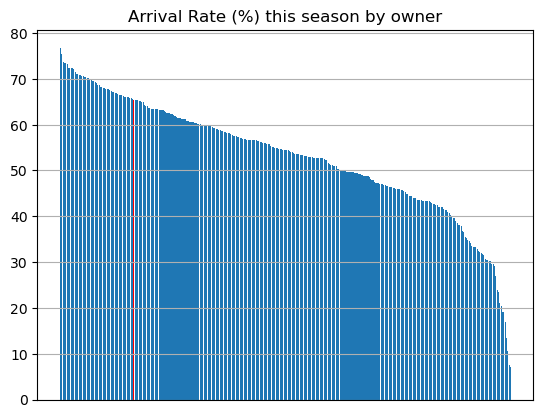

In [12]:
c = ['r' if owner_name == main_owner else 'C0' for owner_name in df_top_arrival_rates.index]
plt.bar(x=df_top_arrival_rates.index, height=df_top_arrival_rates.arrived * 100, color=c)
plt.title('Arrival Rate (%) this season by owner')
plt.grid()
plt.xticks([])
plt.show()

In [13]:
df_races

,club_number,race_id,members_tosses,min_booked_toss_panniers,booked_toss_panniers,min_booked_toss_pigeons,max_booked_toss_pigeons,max_booked_toss_panniers,booked_pigeons,arrived_pigeons,booked_toss_pigeons,number_of_panniers,registered_pigeons,club_name,panniers,density,num_participants,num_member_participants,name_race,id_race,number,status,race_point_name,season_id,race_point_id,price_per_pigeon,price_per_toss_pannier,results_finalised,max_toss_panniers,club_basketing_start_index,release_datetime,dead_time_start,dead_time_end,distance_race,end_of_booking_datetime,end_of_toss_datetime,end_of_qualification_datetime,end_of_result_datetime,max_toss_pigeons_per_member,weather,wind,temperature,conditions,high_basketing_density,transporter_id,toss_cancelled,season_name,transporter_name,status_display,clubs_to_book,name_race_points,id_race_points,duration,active,race_level,latitude,longitude,distance_race_points,federation_num_of_places_function,federation_points_function,race_point_types,arrival_rate,release_epoch,temperature_departure,dew_point_departure,relative_humidity_departure,precipitation_departure,wind_direction_degrees_departure,wind_speed_kph_departure,air_pressure_departure,temperature_channel,dew_point_channel,relative_humidity_channel,precipitation_channel,wind_direction_degrees_channel,wind_speed_kph_channel,air_pressure_channel,wind_direction_compass_channel,wind_direction_compass_departure,wind_speed_beaufort_channel,wind_speed_beaufort_departure,release_month
0,1,601,{},0,1,0,0,0,187,48,0,10.0,185,Sliema Racing Pigeon Club,133 - 142,18.700000,5938.0,770,Pozzallo 1,601,2,RESULTS_CLOSED,Pozzallo,150,1,1.0,0.0,True,50,3.0,2012-11-11 07:30:00,NaN,NaN,100,1352314800000,1352314800000,1352631600000,1352671200000,NaN,Cloudy,SSE,NaN,NaN,False,4,False,2012-2013,Trailer 1 and 2 adjusted,Results closed,NaN,Pozzallo,1,24,True,1,36.700000,14.800000,100,ROUND(QUALIFIED * 0.1),DISTANCE / NUMBER_OF_PLACINGS * (NUMBER_OF_PLA...,Short,0.259459,1352619000000,20.3,16.9,81.0,NaN,150.0,16.6,1017.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENE,NaN,3.0,11
1,2,601,{},0,1,0,0,0,222,37,0,12.0,208,Marsa Racing Pigeon Society,181 - 192,18.500000,5938.0,770,Pozzallo 1,601,2,RESULTS_CLOSED,Pozzallo,150,1,1.0,0.0,True,50,3.0,2012-11-11 07:30:00,NaN,NaN,100,1352314800000,1352314800000,1352631600000,1352671200000,NaN,Cloudy,SSE,NaN,NaN,False,4,False,2012-2013,Trailer 1 and 2 adjusted,Results closed,NaN,Pozzallo,1,24,True,1,36.700000,14.800000,100,ROUND(QUALIFIED * 0.1),DISTANCE / NUMBER_OF_PLACINGS * (NUMBER_OF_PLA...,Short,0.177885,1352619000000,20.3,16.9,81.0,NaN,150.0,16.6,1017.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENE,NaN,3.0,11
2,3,601,{},0,2,0,0,0,517,130,0,28.0,510,Birkirkara Homing Union,284 - 311,18.464285,5938.0,770,Pozzallo 1,601,2,RESULTS_CLOSED,Pozzallo,150,1,1.0,0.0,True,50,3.0,2012-11-11 07:30:00,NaN,NaN,100,1352314800000,1352314800000,1352631600000,1352671200000,NaN,Cloudy,SSE,NaN,NaN,False,4,False,2012-2013,Trailer 1 and 2 adjusted,Results closed,NaN,Pozzallo,1,24,True,1,36.700000,14.800000,100,ROUND(QUALIFIED * 0.1),DISTANCE / NUMBER_OF_PLACINGS * (NUMBER_OF_PLA...,Short,0.254902,1352619000000,20.3,16.9,81.0,NaN,150.0,16.6,1017.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENE,NaN,3.0,11
3,4,601,{},0,0,0,0,0,244,56,0,13.0,244,Hamrun Pigeon Club,259 - 271,18.769230,5938.0,770,Pozzallo 1,601,2,RESULTS_CLOSED,Pozzallo,150,1,1.0,0.0,True,50,3.0,2012-11-11 07:30:00,NaN,NaN,100,1352314800000,1352314800000,1352631600000,1352671200000,NaN,Cloudy,SSE,NaN,NaN,False,4,False,2012-2013,Trailer 1 and 2 adjusted,Results closed,NaN,Pozzallo,1,24,True,1,36.700000,14.800000,100,ROUND(QUALIFIED * 0.1),DISTANCE / NUMBER_OF_PLACINGS * (NUMBER_OF_PLA...,Short,0.229508,1352619000000,20.3,16.9,81.0,NaN,150.0,16.6,1017.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENE,NaN,3.0,11
4,5,601,{},0,0,0,0,0,228,22,0,12.0,205,Ghaqda Hamiem Tal-giri,272 - 283,19.000000,5938.0,770,Pozzallo 1,601,2,RESULTS_CLOSED,Pozzallo,150,1,1.0,0.0,True,50,3.0,2012-11-11 07:30:00,NaN,NaN,100,1352314800000,13523148000

In [14]:
df_race_results_final['arrival_datetime'] = pd.to_datetime(df_race_results_final['arrival_datetime'], unit='ms', errors='ignore')
df_race_results_final

,club_number_race_results,member_id,race_id,season_id_pigeon,pigeon_id,pigeon_ring,pool_participation,disqualified_federation,club_results_complete,arrival_datetime,corrected_datetime,velocity,corrected_arrival_day,federation_placing,velocity_excl_dead,federation_velocity_placing,club_placing,club_points,club_price,federation_points,federation_price,federation_velocity_points,section_placing,section_points,disqualified_club,pool_placing,pool_price,member_loft,club_name_race_results,member_name,season_name_pigeon,race_duration_days,race_name,race_status,race_status_display,race_results_finalized,club_name_trimmed,member_id_str,pigeon_id_str,pigeon_color,corrected_time,federation_participants,federation_velocity_participants,section_participants,club_participants,pool_participation_text,id,state,club_number_pigeon,ring,milage_wins,last_year_level,current_level,owner_id,ring_masked,color,owner_loft_number,id_str,club_name_pigeon,owner_id_str,owner_name,club_number,members_tosses,min_booked_toss_panniers,booked_toss_panniers,min_booked_toss_pigeons,max_booked_toss_pigeons,max_booked_toss_panniers,booked_pigeons,arrived_pigeons,booked_toss_pigeons,number_of_panniers,registered_pigeons,club_name,panniers,density,num_participants,num_member_participants,name_race,id_race,number,status,race_point_name,season_id_race,race_point_id,price_per_pigeon,price_per_toss_pannier,results_finalised,max_toss_panniers,club_basketing_start_index,release_datetime,dead_time_start,dead_time_end,distance_race,end_of_booking_datetime,end_of_toss_datetime,end_of_qualification_datetime,end_of_result_datetime,max_toss_pigeons_per_member,weather,wind,temperature,conditions,high_basketing_density,transporter_id,toss_cancelled,season_name_race,transporter_name,status_display,clubs_to_book,name_race_points,id_race_points,duration,active,race_level,latitude,longitude,distance_race_points,federation_num_of_places_function,federation_points_function,race_point_types,arrival_rate,release_epoch,temperature_departure,dew_point_departure,relative_humidity_departure,precipitation_departure,wind_direction_degrees_departure,wind_speed_kph_departure,air_pressure_departure,temperature_channel,dew_point_channel,relative_humidity_channel,precipitation_channel,wind_direction_degrees_channel,wind_speed_kph_channel,air_pressure_channel,wind_direction_compass_channel,wind_direction_compass_departure,wind_speed_beaufort_channel,wind_speed_beaufort_departure,release_month,arrived
0,1,86926641858612749,601,150,86954993852547597,**-***17-****,False,NaN,True,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,Sliema Racing Pigeon Club,William Cuschieri,2012-2013,1,Pozzallo 1,RESULTS_CLOSED,Results closed,True,Sliema Racing..,86926641858612749,86954993852547597,NaN,NaN,5938,0,0,185,NaN,8.695499e+16,ACTIVE,1.0,01-00117-2011,NaN,0.0,0.0,8.692664e+16,**-***17-****,NaN,1.0,8.695499e+16,Sliema Racing Pigeon Club,8.692664e+16,William Cuschieri,1,{},0,1,0,0,0,187,48,0,10.0,185,Sliema Racing Pigeon Club,133 - 142,18.7,5938.0,770,Pozzallo 1,601,2,RESULTS_CLOSED,Pozzallo,150,1,1.0,0.0,True,50,3.0,2012-11-11 07:30:00,NaN,NaN,100,1352314800000,1352314800000,1352631600000,1352671200000,NaN,Cloudy,SSE,NaN,NaN,False,4,False,2012-2013,Trailer 1 and 2 adjusted,Results closed,NaN,Pozzallo,1,24,True,1,36.700000,14.800000,100,ROUND(QUALIFIED * 0.1),DISTANCE / NUMBER_OF_PLACINGS * (NUMBER_OF_PLA...,Short,0.259459,1352619000000,20.3,16.9,81.0,NaN,150.0,16.6,1017.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENE,NaN,3.0,11,False
1,1,86926641858612749,601,150,86954993950721293,**-***89-****,False,NaN,True,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,Sliema Racing Pigeon Club,William Cuschieri,2012-2013,1,Pozzallo 1,RESULTS_CLOSED,Results closed,True,Sliema Racing..,86926641858612749,86954993950721293,NaN,NaN,5938,0,0,185,NaN,8.695499e+16,ACTIVE,1.0,01-00189-2011,NaN,0.0,0.0,8.692664e+16,**-***89-****,NaN,1.0,8.695499e+16,Sliema Racing Pigeon Club,8.692664e+16,Will

In [15]:
# should be handled on load

def deg_to_compass(degrees: float) -> str:
    """
    Converts a wind direction in degrees to the corresponding compass direction.
    
    Args:
      degrees (float): Wind direction in degrees (0 to 360).
    
    Returns:
      str: The compass direction (e.g., "N", "NE", "SW").
    """

    if degrees is None or np.isnan(degrees):
        return None

    val=int((degrees / 22.5) + .5)
    arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
    return arr[(val % 16)]


In [17]:
groupby = main_owner
df_avg_velocity_direction_main = df_race_results_final[df_race_results_final['owner_name']==main_owner].dropna(subset=['velocity']).groupby(groupby).agg({'velocity': 'mean'}).sort_values('velocity')
df_avg_velocity_direction_all = df_race_results_final.dropna(subset=['velocity']).groupby(groupby).agg({'velocity': 'mean'}).sort_values('velocity')

df_avg_velocity_direction_comp = df_avg_velocity_direction_all.merge(df_avg_velocity_direction_main, how='outer', suffixes=('_all', '_main'), left_index=True, right_index=True)
df_avg_velocity_direction_comp = df_avg_velocity_direction_comp.rename({'velocity_all': 'Overall', 'velocity_main': main_owner}, axis=1)
df_avg_velocity_direction_comp = df_avg_velocity_direction_comp.sort_values(main_owner)

df_avg_velocity_direction_comp_tmp = df_avg_velocity_direction_comp.reset_index()
for rpn in df_avg_velocity_direction_comp_tmp.race_point_name.unique():
    df_avg_velocity_direction_comp_tmp[df_avg_velocity_direction_comp_tmp.race_point_name == rpn].set_index('wind_direction_compass_departure').plot.bar(title=rpn)

KeyError: 'Camilleri Walter'

In [ ]:
df_avg_velocity_direction_comp_tmp

In [ ]:
df_avg_velocity_direction_comp.reset_index()

In [18]:
df_race_results_final.groupby(['race_point_name', 'wind_direction_compass_channel']).agg({'velocity': ['mean', 'std']}).sort_values(('velocity', 'std'))#.plot.bar()

velocity            
                                                      mean         std
race_point_name wind_direction_compass_channel                        
Manfredonia     SSE                               3.312643   30.901099
                E                                 2.131605   35.462281
Brindisi        N                                 6.767653   51.545500
                SE                                8.712014   55.475980
Battipaglia     E                                 7.707251   57.702087
Catanzaro       ESE                              13.208621   61.906411
Bari            SE                               40.058737  110.458461
Falerna         ESE                              19.802718  120.840910
                SSE                              21.835515  127.469202
Bari            NNE                              36.069806  130.031394
Brindisi        E                                32.748043  132.017934
                NNE                              35.000111  135.771687
St Eufemia      ESE                              24.817163  138.688128
Bari            ESE                              64.345442  146.856566
                NE                               53.166984  210.174686
Catanzaro       E                                91.059712  222.532870
Metapunto M     E                                66.373728  227.542201
Pozzallo        ENE                              98.302916  262.827185
Falerna         SE                               86.167492  285.044170
St Eufemia      E                               131.208586  286.589319
Metapunto M     NNE                              79.233293  298.592710
Metapunto L     SE                              163.842243  303.497336
                ENE                             169.327258  305.337886
Bari            ENE                             153.417081  321.007082
Metapunto M     NE                              133.814762  342.445878
Messina         NNE                             105.980940  356.047691
Metapunto M     SSE                             173.777895  361.510019
Catanzaro       SE                              187.349717  376.076206
Metapunto M     N                               122.435161  388.945867
Pozzallo        ESE                             413.189866  424.467567
Messina         ESE                             275.526467  440.677617
                E                               264.957343  441.070634
Belvedere       E                               275.429679  441.621793
Pozzallo        E                               604.626923  442.035802
Metapunto L     SSE                             241.964779  463.548742
                NNE                             270.049604  477.263415
Messina         ENE                             278.575642  480.744165
Belvedere       ESE                             379.812018  482.105929
Pozzallo        SSE                             320.722762  486.388929
                SE                              508.937412  499.153260
                N                               297.255873  503.830104
St Eufemia      NE                              408.859371  520.116304
Catanzaro       ENE                             485.464957  525.212301
Belvedere       SE                              466.742723  527.540302
Messina         NE                              305.936696  531.123191
Belvedere       SSE                             387.137524  534.099989
Reggio          SE                              689.332580  543.545876
Messina         SE                              510.056475  545.115680
Catanzaro       SSE                             343.926682  552.197485
Pozzallo        NNE                             544.943455  552.646691
Messina         SSE                             437.357078  553.254585
St Eufemia      N                               516.133019  553.833059
Belvedere       ENE                             470.400635  564.844567
St Eufemia      SSE                             367.895315  579.170925
Cat

In [19]:
df_race_results_final.describe(include='all')

,club_number_race_results,member_id,race_id,season_id_pigeon,pigeon_id,pigeon_ring,pool_participation,disqualified_federation,club_results_complete,arrival_datetime,corrected_datetime,velocity,corrected_arrival_day,federation_placing,velocity_excl_dead,federation_velocity_placing,club_placing,club_points,club_price,federation_points,federation_price,federation_velocity_points,section_placing,section_points,disqualified_club,pool_placing,pool_price,member_loft,club_name_race_results,member_name,season_name_pigeon,race_duration_days,race_name,race_status,race_status_display,race_results_finalized,club_name_trimmed,member_id_str,pigeon_id_str,pigeon_color,corrected_time,federation_participants,federation_velocity_participants,section_participants,club_participants,pool_participation_text,id,state,club_number_pigeon,ring,milage_wins,last_year_level,current_level,owner_id,ring_masked,color,owner_loft_number,id_str,club_name_pigeon,owner_id_str,owner_name,club_number,members_tosses,min_booked_toss_panniers,booked_toss_panniers,min_booked_toss_pigeons,max_booked_toss_pigeons,max_booked_toss_panniers,booked_pigeons,arrived_pigeons,booked_toss_pigeons,number_of_panniers,registered_pigeons,club_name,panniers,density,num_participants,num_member_participants,name_race,id_race,number,status,race_point_name,season_id_race,race_point_id,price_per_pigeon,price_per_toss_pannier,results_finalised,max_toss_panniers,club_basketing_start_index,release_datetime,dead_time_start,dead_time_end,distance_race,end_of_booking_datetime,end_of_toss_datetime,end_of_qualification_datetime,end_of_result_datetime,max_toss_pigeons_per_member,weather,wind,temperature,conditions,high_basketing_density,transporter_id,toss_cancelled,season_name_race,transporter_name,status_display,clubs_to_book,name_race_points,id_race_points,duration,active,race_level,latitude,longitude,distance_race_points,federation_num_of_places_function,federation_points_function,race_point_types,arrival_rate,release_epoch,temperature_departure,dew_point_departure,relative_humidity_departure,precipitation_departure,wind_direction_degrees_departure,wind_speed_kph_departure,air_pressure_departure,temperature_channel,dew_point_channel,relative_humidity_channel,precipitation_channel,wind_direction_degrees_channel,wind_speed_kph_channel,air_pressure_channel,wind_direction_compass_channel,wind_direction_compass_departure,wind_speed_beaufort_channel,wind_speed_beaufort_departure,release_month,arrived
count,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,1911120,1911120,20276,1911120,935154,9.351480e+05,1.911120e+06,9.351480e+05,179269.000000,577386.000000,109059.000000,353291.000000,1.911120e+06,236440.000000,1.911120e+06,0.0,109059.000000,179364.000000,1.911120e+06,2650,158.000000,158.000000,1.911120e+06,1911120,1911120,1911120,1.911120e+06,1911120,1911120,1911120,1911120,1911120,1.911120e+06,1.911120e+06,74642,9.351480e+05,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,1651,1.889302e+06,1889302,1.889302e+06,1889302,0.0,1.889302e+06,1.889302e+06,1.889302e+06,1889302,73869,1.889302e+06,1.889302e+06,1889302,1.889302e+06,1889302,1.911120e+06,1911120,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,1.894560e+06,1.911120e+06,1911120,1894560,1.894560e+06,1.910971e+06,1.911120e+06,1911120,1.911120e+06,1.911120e+06,1911120,1911120,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,1911120,1.911120e+06,1.894560e+06,1911120,170340,170340,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,872760.000000,5951,5951,0.0,0.0,1911120,1.911120e+06,1911120,1911120,1911120,1911120,0.0,1911120,1.911120e+06,1.911120e+06,1911120,1.911120e+06,1.911120e+06,1.911120e+06,1.911120e+06,1911120,1911120,1911120,1.911120e+06,1.911120e+06,1.579001e+06,1.566102e+06,1.566102e+06,339909.000000,1.519611e+06,1.595257e+06,1.498996e+06,1.468539e+06,1.468539e+06,1.468539e+06,289842.000000,1.424354e+06,1.452426e+06,1.468539e+06,1424354,1519611,1.45242

In [36]:
from requests import Session
import json
import re
import aiohttp
import asyncio
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from functools import cache

from datetime import datetime
from meteostat import Point, Daily, Hourly
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

home_lat, home_lon = 35.935069, 14.491261
sicily_lat, sicily_lon = 36.7228304,14.8160372

@cache
def _get_weather(lat, lon, dt) -> tuple:
    loc = Point(lat, lon, 70)
    dt = datetime(dt.year, dt.month, dt.day, dt.hour)
    try:
        res = Hourly(loc, dt, dt).fetch().iloc[0]
    except IndexError:
        print(f'No weather data for on {dt}@{lat},{lon}')
        return None, None, None, None, None, None, None
    return res.temp, res.dwpt, res.rhum, res.prcp, res.wdir, res.wspd, res.pres
    
def get_geo_weather(x) -> tuple:
    loc = Point(x['latitude'], x['longitude'], 70)
    release_dt = x['release_datetime']
    return _get_weather(x['latitude'], x['longitude'], release_dt)

def get_channel_weather(x) -> tuple:
    release_dt = x['release_datetime']
    return _get_weather(home_lat, home_lon, release_dt)

def get_sicily_weather(x) -> tuple:
    release_dt = pd.Timestamp(x['release_datetime'])
    return _get_weather(sicily_lat, sicily_lon, release_dt)

def deg_to_compass(degrees: float) -> str:
    """
    Converts a wind direction in degrees to the corresponding compass direction.
    
    Args:
      degrees (float): Wind direction in degrees (0 to 360).
    
    Returns:
      str: The compass direction (e.g., "N", "NE", "SW").
    """

    if degrees is None or np.isnan(degrees):
        return None

    val=int((degrees / 22.5) + .5)
    arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
    return arr[(val % 16)]
    

df_race_results_final[['temperature_sicily', 'dew_point_sicily', 'relative_humidity_sicily', 'precipitation_sicily', 'wind_direction_degrees_sicily', 'wind_speed_kph_sicily', 'air_pressure_sicily']] = df_race_results_final.apply(get_sicily_weather, axis=1, result_type='expand')

@cache
def wind_speed_to_beaufort(wind_speed) -> int:
    """
    This function converts wind speed in kilometers per hour (kmph) to the Beaufort scale force.
    
    Args:
    wind_speed: Wind speed in kilometers per hour (kmph).
    
    Returns:
    The Beaufort scale force (integer) or None if wind speed is negative.
    """
    if wind_speed is None or np.isnan(wind_speed) or wind_speed < 0:
        return None
    
    beaufort_scale = {
        0: (0, 1),
        1: (1, 6),
        2: (6, 12),
        3: (12, 20),
        4: (20, 29),
        5: (29, 38),
        6: (38, 50),
        7: (50, 62),
        8: (62, 75),
        9: (75, 89),
        10: (89, 103),
        11: (103, 118),
        12: (118, float('inf')),
    }

    return next(force for force, (lb, ub) in beaufort_scale.items() if lb <= wind_speed < ub)
    
df_race_results_final['wind_direction_compass_sicily'] = df_race_results_final.wind_direction_degrees_sicily.apply(deg_to_compass)
df_race_results_final['wind_speed_beaufort_sicily'] = df_race_results_final.wind_speed_kph_sicily.apply(wind_speed_to_beaufort)
df_race_results_final['release_hour'] = df_race_results_final.release_datetime.apply(pd.Timestamp).dt.hour

No weather data for on 2018-05-27 04:00:00@36.7228304,14.8160372
No weather data for on 2018-06-02 04:00:00@36.7228304,14.8160372


In [21]:
df_race_results_final.head()

,club_number_race_results,member_id,race_id,season_id_pigeon,pigeon_id,pigeon_ring,pool_participation,disqualified_federation,club_results_complete,arrival_datetime,corrected_datetime,velocity,corrected_arrival_day,federation_placing,velocity_excl_dead,federation_velocity_placing,club_placing,club_points,club_price,federation_points,federation_price,federation_velocity_points,section_placing,section_points,disqualified_club,pool_placing,pool_price,member_loft,club_name_race_results,member_name,season_name_pigeon,race_duration_days,race_name,race_status,race_status_display,race_results_finalized,club_name_trimmed,member_id_str,pigeon_id_str,pigeon_color,corrected_time,federation_participants,federation_velocity_participants,section_participants,club_participants,pool_participation_text,id,state,club_number_pigeon,ring,milage_wins,last_year_level,current_level,owner_id,ring_masked,color,owner_loft_number,id_str,club_name_pigeon,owner_id_str,owner_name,club_number,members_tosses,min_booked_toss_panniers,booked_toss_panniers,min_booked_toss_pigeons,max_booked_toss_pigeons,max_booked_toss_panniers,booked_pigeons,arrived_pigeons,booked_toss_pigeons,number_of_panniers,registered_pigeons,club_name,panniers,density,num_participants,num_member_participants,name_race,id_race,number,status,race_point_name,season_id_race,race_point_id,price_per_pigeon,price_per_toss_pannier,results_finalised,max_toss_panniers,club_basketing_start_index,release_datetime,dead_time_start,dead_time_end,distance_race,end_of_booking_datetime,end_of_toss_datetime,end_of_qualification_datetime,end_of_result_datetime,max_toss_pigeons_per_member,weather,wind,temperature,conditions,high_basketing_density,transporter_id,toss_cancelled,season_name_race,transporter_name,status_display,clubs_to_book,name_race_points,id_race_points,duration,active,race_level,latitude,longitude,distance_race_points,federation_num_of_places_function,federation_points_function,race_point_types,arrival_rate,release_epoch,temperature_departure,dew_point_departure,relative_humidity_departure,precipitation_departure,wind_direction_degrees_departure,wind_speed_kph_departure,air_pressure_departure,temperature_channel,dew_point_channel,relative_humidity_channel,precipitation_channel,wind_direction_degrees_channel,wind_speed_kph_channel,air_pressure_channel,wind_direction_compass_channel,wind_direction_compass_departure,wind_speed_beaufort_channel,wind_speed_beaufort_departure,release_month,arrived
0,1,86926641858612749,601,150,86954993852547597,**-***17-****,False,NaN,True,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,Sliema Racing Pigeon Club,William Cuschieri,2012-2013,1,Pozzallo 1,RESULTS_CLOSED,Results closed,True,Sliema Racing..,86926641858612749,86954993852547597,NaN,NaN,5938,0,0,185,NaN,8.695499e+16,ACTIVE,1.0,01-00117-2011,NaN,0.0,0.0,8.692664e+16,**-***17-****,NaN,1.0,8.695499e+16,Sliema Racing Pigeon Club,8.692664e+16,William Cuschieri,1,{},0,1,0,0,0,187,48,0,10.0,185,Sliema Racing Pigeon Club,133 - 142,18.7,5938.0,770,Pozzallo 1,601,2,RESULTS_CLOSED,Pozzallo,150,1,1.0,0.0,True,50,3.0,2012-11-11 07:30:00,NaN,NaN,100,1352314800000,1352314800000,1352631600000,1352671200000,NaN,Cloudy,SSE,NaN,NaN,False,4,False,2012-2013,Trailer 1 and 2 adjusted,Results closed,NaN,Pozzallo,1,24,True,1,36.7,14.8,100,ROUND(QUALIFIED * 0.1),DISTANCE / NUMBER_OF_PLACINGS * (NUMBER_OF_PLA...,Short,0.259459,1352619000000,20.3,16.9,81.0,NaN,150.0,16.6,1017.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENE,NaN,3.0,11,False
1,1,86926641858612749,601,150,86954993950721293,**-***89-****,False,NaN,True,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,Sliema Racing Pigeon Club,William Cuschieri,2012-2013,1,Pozzallo 1,RESULTS_CLOSED,Results closed,True,Sliema Racing..,86926641858612749,86954993950721293,NaN,NaN,5938,0,0,185,NaN,8.695499e+16,ACTIVE,1.0,01-00189-2011,NaN,0.0,0.0,8.692664e+16,**-***89-****,NaN,1.0,8.695499e+16,Sliema Racing Pigeon Club,8.692664e+16,William Cuschi

# Feature Engineering
## Recent Performance
The below code takes each pigeon's historical performance, and exponentially averages previous race velocities (without using the current data point). The exponential weighting is based on the distance since the last race, where half of the weighting is lost after 60 days.

In [22]:
df_race_results_final = df_race_results_final.sort_values(['pigeon_id', 'release_datetime']).reset_index(drop=True)
df_race_results_final['velocity_lag'] = df_race_results_final.groupby('pigeon_id').velocity.shift()
df_race_results_final['race_count'] = df_race_results_final.groupby('pigeon_id').velocity_lag.cumcount()
df_race_results_final['total_race_count'] = df_race_results_final.groupby('pigeon_id').pigeon_id.transform('count')
df_race_results_final['velocity_form'] = df_race_results_final.groupby('pigeon_id').velocity_lag.ewm(halflife='60 days', times=pd.DatetimeIndex(df_race_results_final.release_datetime)).mean().values
df_race_results_final['velocity_form_linear'] = df_race_results_final.groupby('pigeon_id').velocity_lag.expanding().mean().values

In [23]:
df_race_results_final['is_federation_placed'] = df_race_results_final.federation_points.fillna(0) > 0

## Categorise Covariates

In [24]:
df_race_results_final['is_headwind'] = (df_race_results_final.wind_direction_degrees_channel > 135)&(df_race_results_final.wind_direction_degrees_channel < 270)
df_race_results_final['wind_direction_compass_departure'] = df_race_results_final.wind_direction_degrees_departure.apply(deg_to_compass)
df_race_results_final['wind_direction_compass_channel'] = df_race_results_final.wind_direction_degrees_channel.apply(deg_to_compass)

## Feature Selection
We add a feature with random numbers which will be used to compare other features to it. 
Any feature performing worse can be considered uninoformative.

In [25]:
df_race_results_final['rnd'] = np.random.normal(size=len(df_race_results_final))

## Geomagnetic Data
We use the Kp index to measure the Earth's magnetic force. It is thought that this feature affects pigeons' homing ability.

In [26]:
import requests
index = 'Kp'
start='2010-01-01T00:00:00Z'
end='2025-01-01T00:00:00Z'
url = f'https://kp.gfz-potsdam.de/app/json/?start={start}&end={end}&index={index}&status=def'
res = requests.get(url).json()
df_mag = pd.DataFrame({k: v for k, v in res.items() if k in ['datetime', 'Kp']})
df_mag.datetime = df_mag.datetime.apply(pd.Timestamp)

<Axes: title={'center': 'Planetory Kp Index'}, xlabel='datetime'>

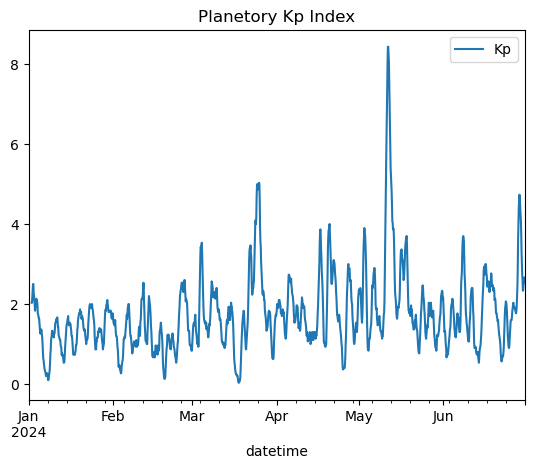

In [27]:
df_mag[df_mag.datetime>='2024-01-01'].set_index('datetime').rolling(10).mean().plot(title='Planetory Kp Index')

In [28]:
df_race_results_final['release_datetime_pdtimestamp'] = df_race_results_final.release_datetime.apply(lambda x: pd.Timestamp(x, tz='UTC'))

In [29]:
df_race_results_final = pd.merge_asof(df_race_results_final.sort_values('release_datetime_pdtimestamp'), df_mag, left_on='release_datetime_pdtimestamp', right_on='datetime', direction='nearest')

<Axes: xlabel='Kp'>

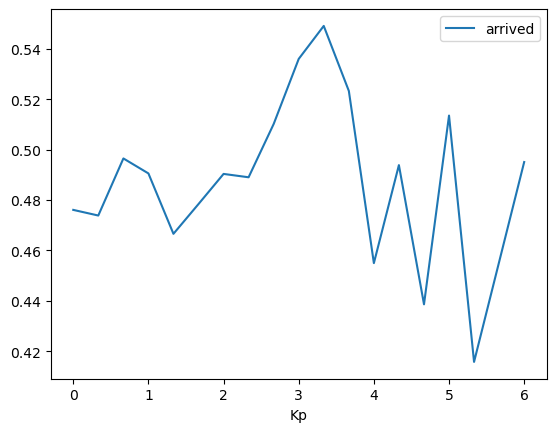

In [30]:
df_race_results_final[['arrived', 'Kp']].groupby('Kp').mean().plot()

# Modelling
We perform two models:

* We first try to model the data as a regression problem, where we try to predict the velocity.
* We then take a simpler approach and treat the problem as a binary problem, trying to predict whtether a pigeon will place or not.

In both cases we use LGBM since it is the most efficient model time-wise, and cnosidered a good model for tabular data. No normalisation and standardisation and one-hot encoding is necessary for this model.

## Modelling Velocity

In [31]:
important_features = [
    'race_point_types',
    'temperature_channel',
    'relative_humidity_channel',
    'wind_direction_compass_channel',
    'wind_direction_compass_departure',
    'current_level',
    'pigeon_id',
    'wind_speed_kph_departure',
    'dew_point_channel',
]

In [32]:
pred_col = 'velocity'

covariates = [
    'temperature_departure', 
    'temperature_channel', 
    
    'dew_point_departure', 
    'dew_point_channel', 
    
    'distance_race_points',
    
    'relative_humidity_departure', 
    'relative_humidity_channel', 
    'relative_humidity_sicily', 
    
    # 'precipitation_channel', 
    # 'precipitation_departure', 
    
    'wind_direction_degrees_departure', 
    'wind_direction_degrees_channel', 
    'wind_direction_degrees_sicily', 
    
    'wind_speed_kph_departure', 
    'wind_speed_kph_channel', 
    'wind_speed_kph_sicily', 
    
    'air_pressure_departure', 
    'air_pressure_channel',
    'air_pressure_sicily',
    
    'wind_speed_beaufort_departure', 
    'wind_speed_beaufort_channel', 
    'wind_speed_beaufort_sicily', 
    
    'current_level', 
    'last_year_level',

    'rnd',
    'race_count',
    'velocity_form',
    'velocity_lag',
    'velocity_form_linear',

    'registered_pigeons',
    'release_hour',

    'Kp',
]

categorical = [
    'race_point_name', 
    'wind_direction_compass_channel', 
    'wind_direction_compass_departure', 
    'release_month', 
    'race_name', 
    'race_point_types', 
    'is_headwind',
    
    'pigeon_id', 
    'owner_id', 
]

In [37]:
df_corr = df_race_results_final[covariates].corr()

In [38]:
pd.set_option('display.max_rows', None)
df_corr_sorted = df_corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
df_corr_sorted[(0.7 < df_corr_sorted)&(df_corr_sorted < 1)]

air_pressure_channel           air_pressure_sicily              0.979498
air_pressure_sicily            air_pressure_channel             0.979498
                               air_pressure_departure           0.979353
air_pressure_departure         air_pressure_sicily              0.979353
velocity_form_linear           velocity_form                    0.978298
velocity_form                  velocity_form_linear             0.978298
air_pressure_departure         air_pressure_channel             0.970354
air_pressure_channel           air_pressure_departure           0.970354
wind_speed_beaufort_departure  wind_speed_kph_departure         0.964123
wind_speed_kph_departure       wind_speed_beaufort_departure    0.964123
wind_speed_kph_channel         wind_speed_beaufort_channel      0.963216
wind_speed_beaufort_channel    wind_speed_kph_channel           0.963216
wind_speed_beaufort_sicily     wind_speed_kph_sicily            0.957151
wind_speed_kph_sicily          wind_speed_beaufort_

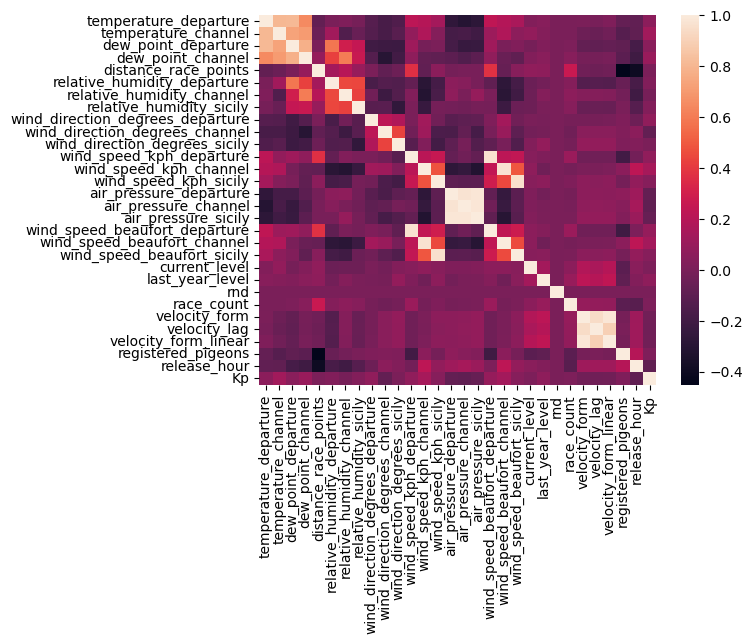

In [39]:
sns.heatmap(df_corr, annot=False, xticklabels=True, yticklabels=True);

In [40]:
train_start = '2018-01-01'
train_end = '2023-01-01'

important_features = [
    'race_point_name',
    'dew_point_departure',
    'air_pressure_channel',
    'dew_point_channel',
    'wind_direction_compass_departure',
    'last_year_level',
    'precipitation_channel',
    'relative_humidity_departure',
    'release_month',
    'rnd',
]

important_features = categorical + covariates  # comment if we want specific features

important_categorical = list(set(categorical) & set(important_features))
important_covariates = list(set(covariates) & set(important_features))

Xy =  df_race_results_final[
    (df_race_results_final.release_datetime >= train_start)&
    (df_race_results_final.total_race_count > 1)&
    (df_race_results_final.velocity > 50)]

label_encoders = {}
for c in important_categorical:
    print(c)
    labelencoder = LabelEncoder()
    Xy.loc[:,c] = labelencoder.fit_transform(Xy[c])
    label_encoders[c] = labelencoder

Xy[important_categorical] = Xy[important_categorical].astype(float)

Xy_train = Xy[(Xy.release_datetime >= train_start)&(Xy.release_datetime < train_end)]
Xy_test = Xy[Xy.release_datetime >= train_end]

X_train = Xy_train[important_categorical + important_covariates]
y_train = Xy_train.velocity

X_test = Xy_test[important_categorical + important_covariates]
y_test = Xy_test.velocity

train_data = lgb.Dataset(
    X_train, 
    label=y_train,
    feature_name=list(set(important_categorical + important_covariates)),
    categorical_feature=important_categorical
)

release_month
is_headwind
race_name
race_point_name
owner_id
wind_direction_compass_departure
pigeon_id
wind_direction_compass_channel
race_point_types


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
param = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    # 'metric':metrics,
    'learning_rate': 0.1,
    'metric': 'rmse',

    # 'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
    'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
    'max_depth': -1,  # -1 means no limit
    'min_child_samples': 10,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 255,  # Number of bucketed bin for feature values
    'subsample': 0.2,  # Subsample ratio of the training instance.
    'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.6,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': 200_000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': 4,
    'verbose': 0,
    'n_estimators': 100,
    # 'scale_pos_weight': 0.5???,
}

In [42]:
param_velocity_gc = {
    # 'metric':metrics,
    'learning_rate': [0.01, 0.05, 0.1],

    # 'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
    'num_leaves': [31, 63],  # we should let it be smaller than 2^(max_depth)
    'max_depth': [-1],  # -1 means no limit
    'min_child_samples': [10, 20, 40],  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': [255],  # Number of bucketed bin for feature values
    'subsample': [0.2, 0.6],  # Subsample ratio of the training instance.
    'subsample_freq': [0],  # frequence of subsample, <=0 means no enable
    'colsample_bytree': [0.3, 0.6],  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': [5],  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': [200_000],  # Number of samples for constructing bin
    'min_split_gain': [0],  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': [0],  # L1 regularization term on weights
    'reg_lambda': [0],  # L2 regularization term on weights
    'nthread': [4],
    'verbose': [0],
    'n_estimators': [200],
    # 'scale_pos_weight': 0.5???,
}

In [43]:
def get_best_model(params, metric, X_train, y_train, X_test=None, y_test=None, **model_kwargs):
    model_velocity = lgb.LGBMRegressor(metric=metric, **model_kwargs)
    best_score = np.inf
    best_grid = None
    grid = list(ParameterGrid(params))
    n = len(grid)
    for i, g in enumerate(grid, start=1):
        print(f'Training model {i} of {n}...')
        model_velocity.set_params(**g)
        eval_set = [(X_train, y_train)] if X_test is None else [(X_test, y_test), (X_train, y_train)]
        model_velocity.fit(X_train, y_train, eval_set=eval_set)
    
        model_best_score = model_velocity._best_score['valid_0'][metric]
        if model_best_score < best_score:
            print('New best model!')
            print(f'{metric}: {model_best_score}')
            display(g)
            best_score = model_best_score
            best_grid = g
            
    return best_grid

In [44]:
grid_search = False
if grid_search:
    model_kwargs = dict(objective="regression", boosting_type='gbdt', random_state=42)
    best_grid = get_best_model(param_velocity_gc, 'rmse', X_train, y_train, X_test, y_test, **model_kwargs)
    display(best_grid)
    param = best_grid

In [45]:
model_velocity = lgb.LGBMRegressor(**param)
model_velocity.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])

LGBMRegressor(colsample_bytree=0.6, max_bin=255, metric='rmse',
              min_child_samples=10, min_child_weight=5, min_split_gain=0,
              nthread=4, objective='regression', reg_alpha=0, reg_lambda=0,
              subsample=0.2, verbose=0)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

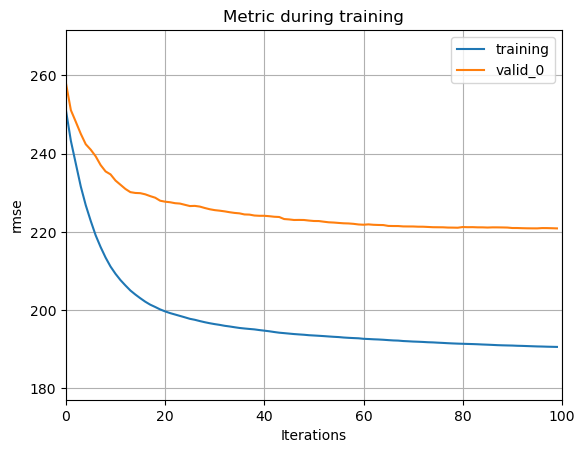

In [46]:
lgb.plot_metric(model_velocity.evals_result_)

Text(0.5, 1.0, 'Velocity prediction: Test data (MSE=220.89)')

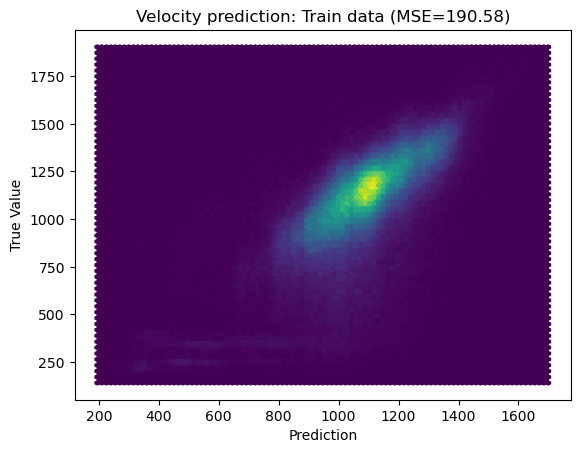

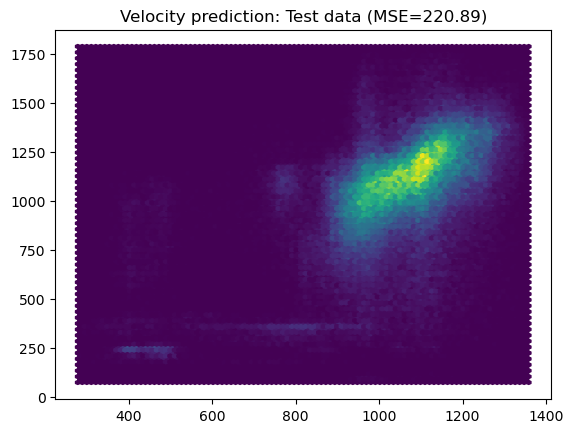

In [47]:
y_pred = model_velocity.predict(X_train)

train_rmse = np.sqrt(mean_squared_error(y_pred, y_train))

plt.hexbin(y_pred, y_train)
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.title(f'Velocity prediction: Train data (MSE={train_rmse:.2f})')

plt.figure()

y_pred = model_velocity.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_pred, y_test))

plt.hexbin(y_pred, y_test)
plt.title(f'Velocity prediction: Test data (MSE={test_rmse:.2f})')

In [48]:
y_comparison = y_test.to_frame()
y_comparison['pred'] = y_pred
y_comparison['diff'] = abs(y_pred -  y_test)
y_comparison = y_comparison.sort_values('diff')
display(y_comparison.head(10))
display(y_comparison.tail(10))

,velocity,pred,diff
1828939,1182.6022,1182.603798,0.001598
1853796,990.9318,990.936071,0.004271
1778390,1141.3770,1141.370116,0.006884
1709357,1116.8628,1116.870743,0.007943
1740045,356.3394,356.330527,0.008873
1709953,963.4116,963.398015,0.013585
1718329,1107.0612,1107.047583,0.013617
1825248,1167.4354,1167.451138,0.015738
1726790,1145.5034,1145.520260,0.016860
1691626,1014.0193,1014.001092,0.018208


,velocity,pred,diff
1743811,102.0305,1050.297947,948.267447
1743340,105.1415,1053.993945,948.852445
1743639,102.6851,1091.914387,989.229287
1746569,86.3125,1080.486810,994.174310
1743849,101.3811,1095.987574,994.606474
1810945,267.9923,1277.188680,1009.196380
1746054,113.1029,1126.785798,1013.682898
1744542,100.9973,1126.329482,1025.332182
1744730,103.0201,1146.367866,1043.347766
1744124,110.4881,1170.581927,1060.093827


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

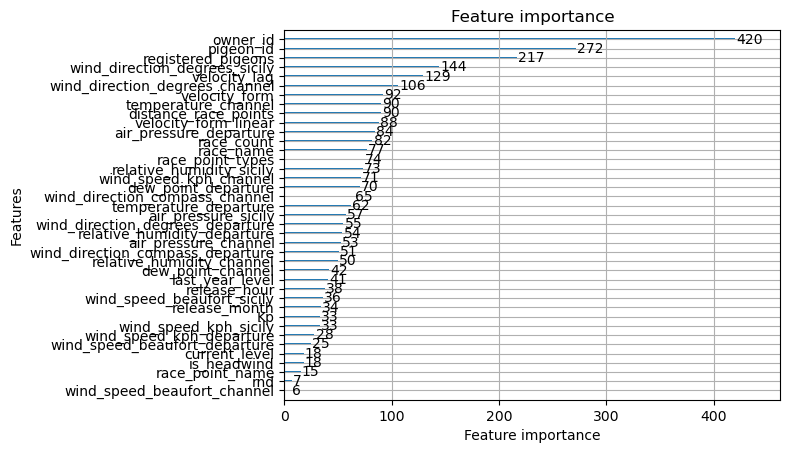

In [49]:
lgb.plot_importance(model_velocity)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

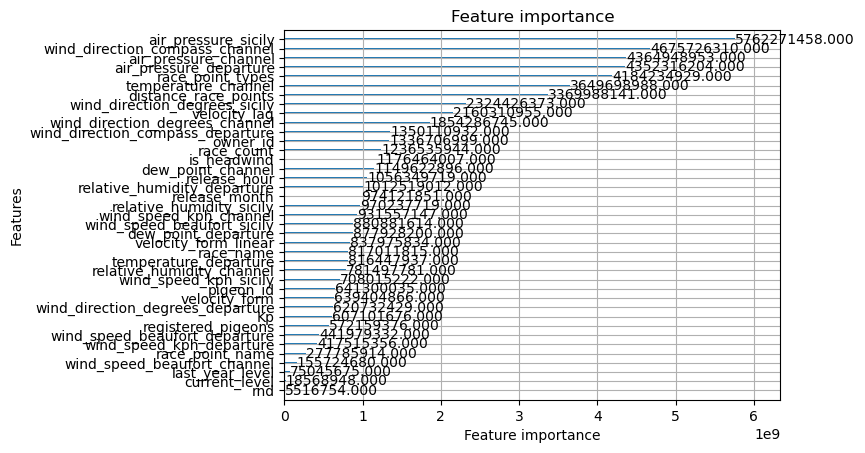

In [50]:
lgb.plot_importance(model_velocity, importance_type="gain")

In [51]:
feature_importances = {f: imp for imp, f in zip(model_velocity.feature_importances_, model_velocity.feature_name_)}
feature_importances = {k: v for k, v in feature_importances.items() if v > feature_importances['rnd']}
dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

{'owner_id': 420,
 'pigeon_id': 272,
 'registered_pigeons': 217,
 'wind_direction_degrees_sicily': 144,
 'velocity_lag': 129,
 'wind_direction_degrees_channel': 106,
 'velocity_form': 92,
 'distance_race_points': 90,
 'temperature_channel': 90,
 'velocity_form_linear': 88,
 'air_pressure_departure': 84,
 'race_count': 82,
 'race_name': 77,
 'race_point_types': 74,
 'relative_humidity_sicily': 73,
 'wind_speed_kph_channel': 71,
 'dew_point_departure': 70,
 'wind_direction_compass_channel': 65,
 'temperature_departure': 62,
 'air_pressure_sicily': 57,
 'wind_direction_degrees_departure': 55,
 'relative_humidity_departure': 54,
 'air_pressure_channel': 53,
 'wind_direction_compass_departure': 51,
 'relative_humidity_channel': 50,
 'dew_point_channel': 42,
 'last_year_level': 41,
 'release_hour': 38,
 'wind_speed_beaufort_sicily': 36,
 'release_month': 34,
 'wind_speed_kph_sicily': 33,
 'Kp': 33,
 'wind_speed_kph_departure': 28,
 'wind_speed_beaufort_departure': 25,
 'is_headwind': 18,
 'c

## Modelling Arrival Rate

In [52]:
param = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    # 'metric':metrics,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',  # Classification metric (log loss).....use auc?

    # 'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
    'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
    'max_depth': -1,  # -1 means no limit
    'min_child_samples': 10,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 255,  # Number of bucketed bin for feature values
    'subsample': 0.2,  # Subsample ratio of the training instance.
    'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.6,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': 200_000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': 4,
    'verbose': 0,
    'n_estimators': 200,
    # 'scale_pos_weight': 0.5???,
}

In [53]:
train_start = '2018-01-01'
train_end = '2023-01-01'

important_features = [
    'race_point_name',
    'dew_point_departure',
    'air_pressure_channel',
    'dew_point_channel',
    'wind_direction_compass_departure',
    'last_year_level',
    'precipitation_channel',
    'relative_humidity_departure',
    'release_month',
    'rnd',
]

important_features = categorical + covariates  # comment if we want specific features

important_categorical = list(set(categorical) & set(important_features))
important_covariates = list(set(covariates) & set(important_features))

Xy =  df_race_results_final[(df_race_results_final.release_datetime >= train_start)&(df_race_results_final.total_race_count > 1)]

label_encoders = {}
for c in important_categorical:
    print(c)
    labelencoder = LabelEncoder()
    Xy.loc[:,c] = labelencoder.fit_transform(Xy[c])
    label_encoders[c] = labelencoder

Xy[important_categorical] = Xy[important_categorical].astype(float)

Xy_train = Xy[(Xy.release_datetime >= train_start)&(Xy.release_datetime < train_end)]
Xy_test = Xy[Xy.release_datetime >= train_end]

X_train = Xy_train[important_categorical + important_covariates]
y_train = Xy_train.arrived

X_test = Xy_test[important_categorical + important_covariates]
y_test = Xy_test.arrived

train_data = lgb.Dataset(
    X_train, 
    label=y_train,
    feature_name=list(set(important_categorical + important_covariates)),
    categorical_feature=important_categorical
)

release_month
is_headwind
race_name
race_point_name
owner_id
wind_direction_compass_departure
pigeon_id
wind_direction_compass_channel
race_point_types


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [54]:
grid_search = False

param_arrival_gc = {
    # 'metric':metrics,
    'learning_rate': [0.01, 0.05, 0.1],

    # 'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
    'num_leaves': [31, 63],  # we should let it be smaller than 2^(max_depth)
    'max_depth': [-1],  # -1 means no limit
    'min_child_samples': [10, 20, 40],  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': [255],  # Number of bucketed bin for feature values
    'subsample': [0.2, 0.6],  # Subsample ratio of the training instance.
    'subsample_freq': [0],  # frequence of subsample, <=0 means no enable
    'colsample_bytree': [0.3, 0.6],  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': [5],  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': [200_000],  # Number of samples for constructing bin
    'min_split_gain': [0],  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': [0],  # L1 regularization term on weights
    'reg_lambda': [0],  # L2 regularization term on weights
    'nthread': [4],
    'verbose': [0],
    'n_estimators': [300],
    # 'scale_pos_weight': 0.5???,
}

if grid_search:
    model_kwargs = dict(objective="binary", boosting_type='gbdt', random_state=42)
    best_grid = get_best_model(param_arrival_gc, 'binary_logloss', X_train, y_train, X_test, y_test, **model_kwargs)
    display(best_grid)
    param = best_grid

In [55]:
model_arrival = lgb.LGBMClassifier(**param)
model_arrival.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.01, max_bin=255,
               metric='binary_logloss', min_child_samples=10,
               min_child_weight=5, min_split_gain=0, n_estimators=200,
               nthread=4, num_leaves=64, objective='binary', reg_alpha=0,
               reg_lambda=0, subsample=0.2, verbose=0)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

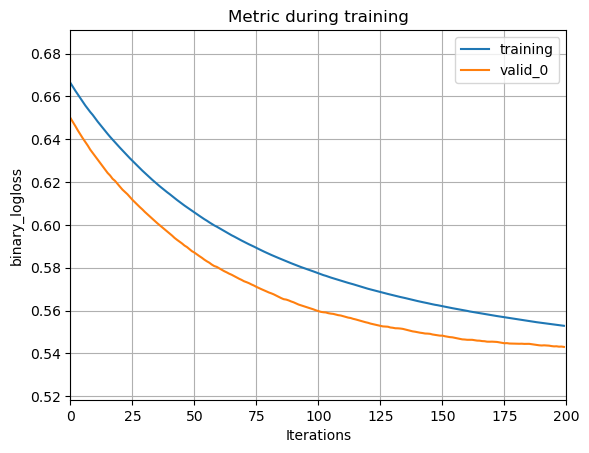

In [56]:
lgb.plot_metric(model_arrival)

In [57]:
y_pred_train = model_arrival.predict_proba(X_train)[:,1]
y_pred = model_arrival.predict_proba(X_test)[:,1]

In [58]:
t = 0.7

print('------------ TRAIN DATA ------------')
print(classification_report(y_train, y_pred_train > t))
print(confusion_matrix(y_train, y_pred_train > t))


print('------------ TEST DATA ------------')
print(classification_report(y_test, y_pred > t))
print(confusion_matrix(y_test, y_pred > t))

------------ TRAIN DATA ------------
              precision    recall  f1-score   support

       False       0.54      0.84      0.66    263144
        True       0.84      0.55      0.66    413786

    accuracy                           0.66    676930
   macro avg       0.69      0.69      0.66    676930
weighted avg       0.72      0.66      0.66    676930

[[219860  43284]
 [187955 225831]]
------------ TEST DATA ------------
              precision    recall  f1-score   support

       False       0.59      0.71      0.64     73461
        True       0.82      0.73      0.77    134746

    accuracy                           0.72    208207
   macro avg       0.70      0.72      0.71    208207
weighted avg       0.74      0.72      0.73    208207

[[51936 21525]
 [36236 98510]]


In [59]:
y_comparison = y_test.to_frame()
y_comparison['pred'] = y_pred
y_comparison[:200]

,arrived,pred
1669120,False,0.497200
1669121,False,0.592942
1669122,False,0.522965
1669123,False,0.261305
1669124,False,0.566060
1669125,False,0.516364
1669126,True,0.539794
1669127,True,0.497200
1669128,True,0.537688
1669129,False,0.565702


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

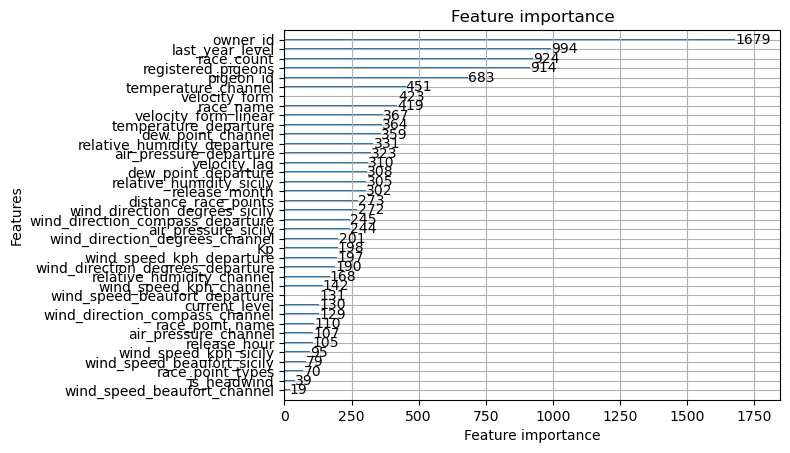

In [60]:
lgb.plot_importance(model_arrival)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

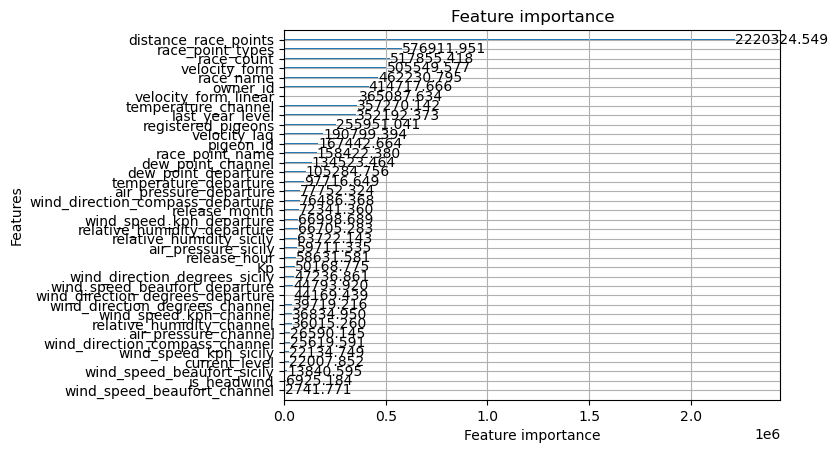

In [61]:
lgb.plot_importance(model_arrival, importance_type='gain')

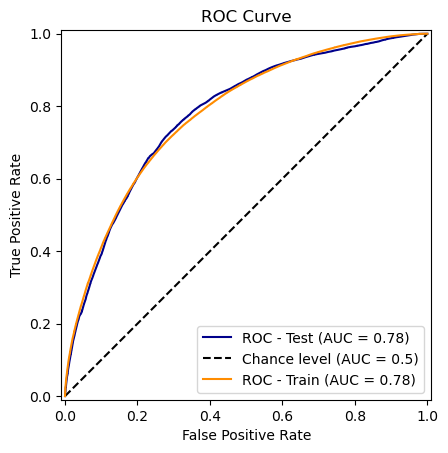

In [62]:
roc_display = RocCurveDisplay.from_predictions(
    y_test,
    y_pred,
    name="ROC - Test",
    color="darkblue",
    plot_chance_level=True,
)

roc_display = RocCurveDisplay.from_predictions(
    y_train,
    y_pred_train,
    name="ROC - Train",
    color="darkorange",
    plot_chance_level=False,
    ax = roc_display.ax_
)

_ = roc_display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve",
)

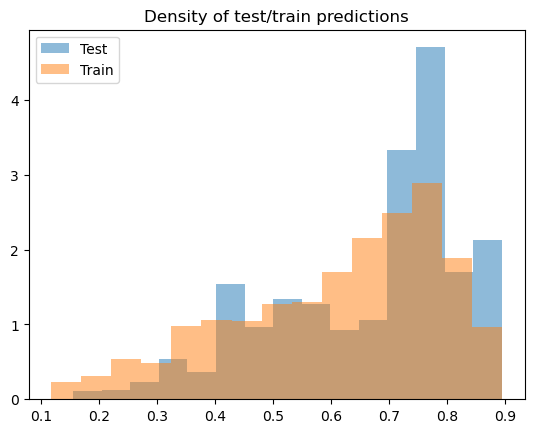

In [63]:
plt.hist(y_pred, bins=15, alpha=0.5, label='Test', density=True)
plt.hist(y_pred_train, bins=15, alpha=0.5, label='Train', density=True)
plt.title('Density of test/train predictions')
plt.legend()

In [64]:
feature_importances = {f: imp for imp, f in zip(model_arrival.feature_importances_, model_arrival.feature_name_)}
feature_importances = {k: v for k, v in feature_importances.items() if v > feature_importances['rnd']}
dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

{'owner_id': 1679,
 'last_year_level': 994,
 'race_count': 924,
 'registered_pigeons': 914,
 'pigeon_id': 683,
 'temperature_channel': 451,
 'velocity_form': 423,
 'race_name': 419,
 'velocity_form_linear': 367,
 'temperature_departure': 364,
 'dew_point_channel': 359,
 'relative_humidity_departure': 331,
 'air_pressure_departure': 323,
 'velocity_lag': 310,
 'dew_point_departure': 308,
 'relative_humidity_sicily': 305,
 'release_month': 302,
 'distance_race_points': 273,
 'wind_direction_degrees_sicily': 272,
 'wind_direction_compass_departure': 245,
 'air_pressure_sicily': 244,
 'wind_direction_degrees_channel': 201,
 'Kp': 198,
 'wind_speed_kph_departure': 197,
 'wind_direction_degrees_departure': 190,
 'relative_humidity_channel': 168,
 'wind_speed_kph_channel': 142,
 'wind_speed_beaufort_departure': 131,
 'current_level': 130,
 'wind_direction_compass_channel': 129,
 'race_point_name': 110,
 'air_pressure_channel': 107,
 'release_hour': 105,
 'wind_speed_kph_sicily': 95,
 'wind_sp

In [65]:
Xy[important_covariates + important_categorical].head()

,wind_speed_beaufort_sicily,relative_humidity_departure,relative_humidity_channel,dew_point_channel,relative_humidity_sicily,distance_race_points,wind_direction_degrees_sicily,air_pressure_departure,wind_speed_kph_channel,release_hour,wind_speed_kph_sicily,wind_speed_beaufort_departure,dew_point_departure,wind_direction_degrees_departure,velocity_lag,temperature_channel,temperature_departure,wind_direction_degrees_channel,wind_speed_beaufort_channel,last_year_level,race_count,air_pressure_channel,velocity_form,registered_pigeons,rnd,air_pressure_sicily,current_level,wind_speed_kph_departure,velocity_form_linear,Kp,release_month,is_headwind,race_name,race_point_name,owner_id,wind_direction_compass_departure,pigeon_id,wind_direction_compass_channel,race_point_types
885538,2.0,81.0,83.0,14.2,67.0,280,140.0,1018.6,30.0,7,9.4,4.0,11.7,210.0,0.0000,17.1,14.9,170.0,5.0,0.0,6,1017.0,0.000000,352,-0.362241,NaN,0.0,27.7,0.000000,0.0,0.0,1.0,24.0,5.0,182.0,9.0,20970.0,8.0,2.0
885539,2.0,81.0,83.0,14.2,67.0,280,140.0,1018.6,30.0,7,9.4,4.0,11.7,210.0,0.0000,17.1,14.9,170.0,5.0,0.0,2,1017.0,0.000000,352,-0.328656,NaN,0.0,27.7,0.000000,0.0,0.0,1.0,24.0,5.0,163.0,9.0,20512.0,8.0,2.0
885540,2.0,81.0,83.0,14.2,67.0,280,140.0,1018.6,30.0,7,9.4,4.0,11.7,210.0,1079.3875,17.1,14.9,170.0,5.0,0.0,3,1017.0,634.404342,352,-1.325183,NaN,0.0,27.7,639.768533,0.0,0.0,1.0,24.0,5.0,178.0,9.0,20894.0,8.0,2.0
885541,2.0,81.0,83.0,14.2,67.0,280,140.0,1018.6,30.0,7,9.4,4.0,11.7,210.0,0.0000,17.1,14.9,170.0,5.0,0.0,2,1017.0,0.000000,352,0.799566,NaN,0.0,27.7,0.000000,0.0,0.0,1.0,24.0,5.0,156.0,9.0,20188.0,8.0,2.0
885542,2.0,81.0,83.0,14.2,67.0,280,140.0,1018.6,30.0,7,9.4,4.0,11.7,210.0,0.0000,17.1,14.9,170.0,5.0,0.0,3,1017.0,0.000000,352,1.776582,NaN,0.0,27.7,0.000000,0.0,0.0,1.0,24.0,5.0,837.0,9.0,20359.0,8.0,2.0


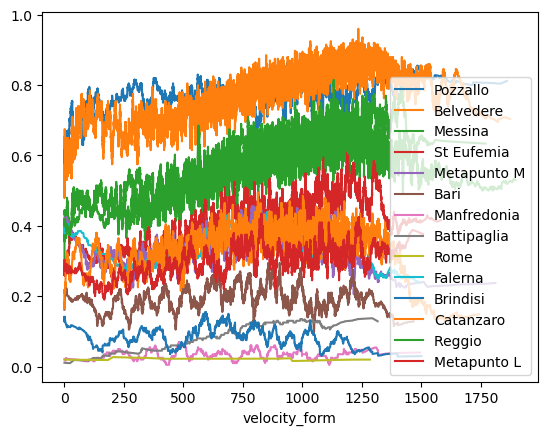

In [66]:
for rpn in df_race_results_final.race_point_name.unique():
    df_race_results_final[df_race_results_final.race_point_name==rpn].groupby('velocity_form').arrived.mean().rolling(200, min_periods=1, center=True).mean().sort_index().plot(label=rpn)
plt.legend()

<Axes: >

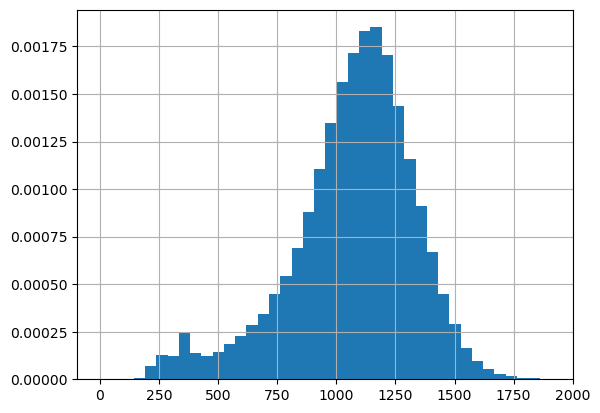

In [67]:
df_race_results_final[df_race_results_final.velocity > 0].velocity.hist(density=True, bins=40)

race_point_name
wind_direction_compass_channel
wind_direction_compass_departure
release_month
race_name
race_point_types
is_headwind


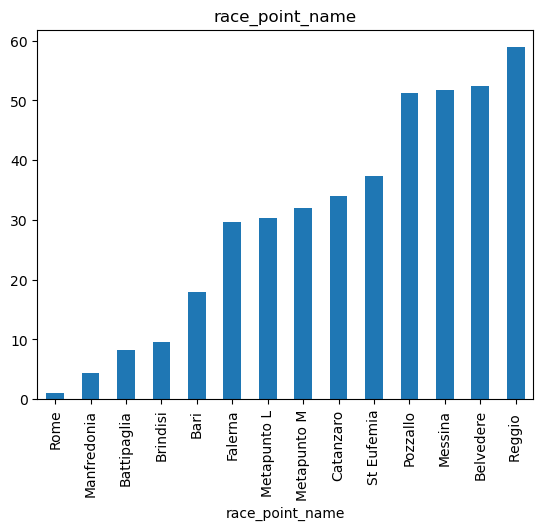

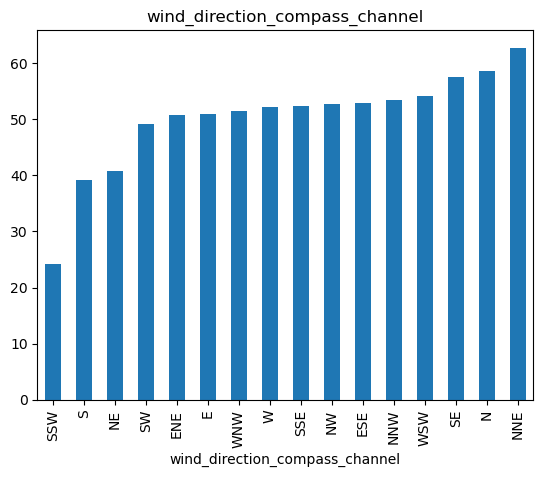

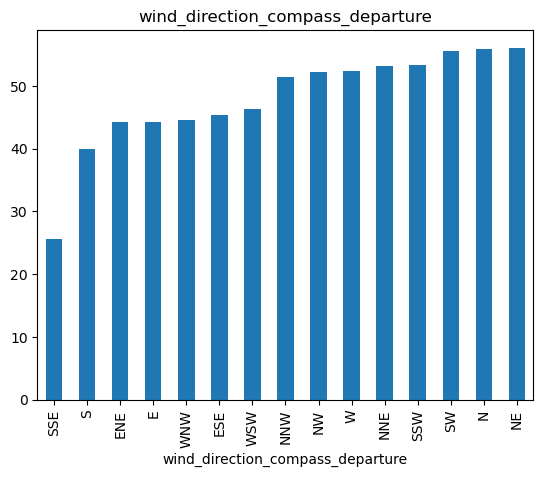

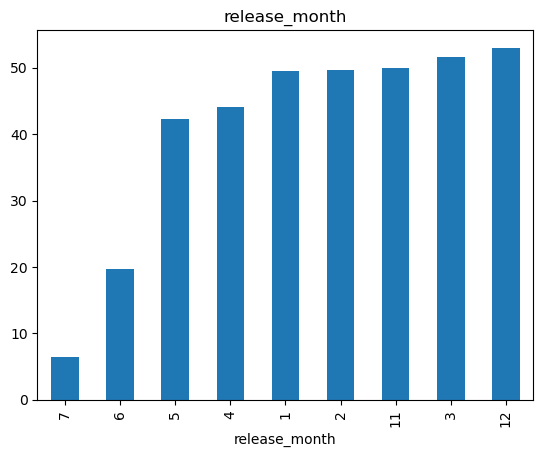

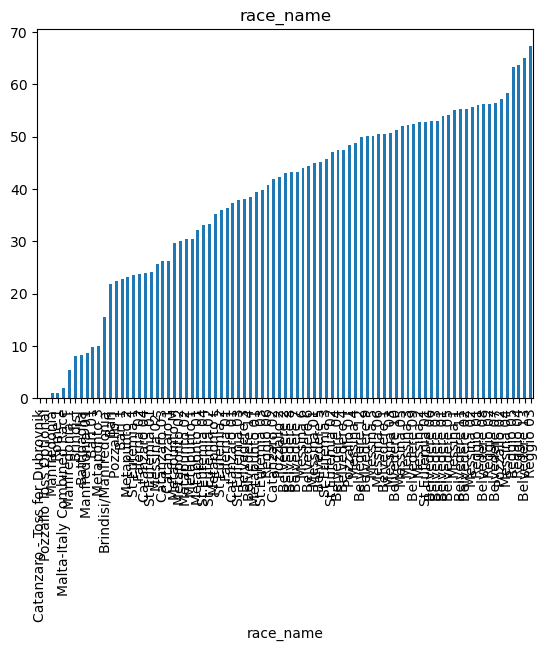

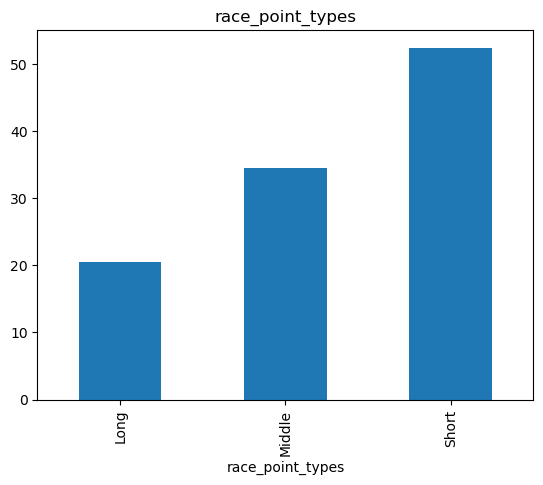

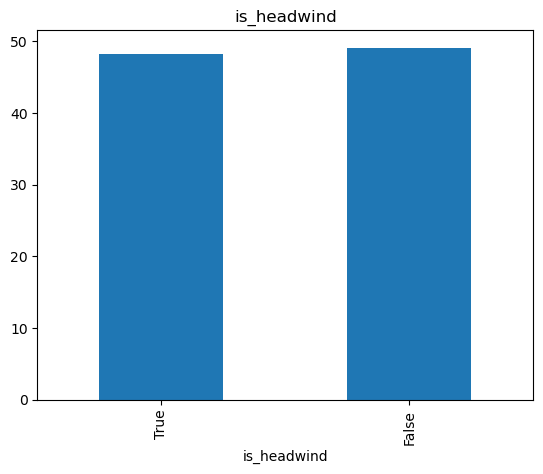

<Figure size 640x480 with 0 Axes>

In [68]:
for cat in categorical:
    if cat in ['owner_id', 'pigeon_id']:
        continue
    print(cat)
    df_race_results_final.groupby(cat).arrived.mean().mul(100).sort_values().plot.bar()
    plt.title(cat)
    plt.figure()

temperature_departure
dew_point_departure
distance_race_points
relative_humidity_departure
wind_direction_degrees_departure
wind_speed_kph_departure
air_pressure_departure
wind_speed_beaufort_departure
current_level
last_year_level
rnd
race_count
velocity_form
velocity_lag
velocity_form_linear
registered_pigeons
release_hour
Kp


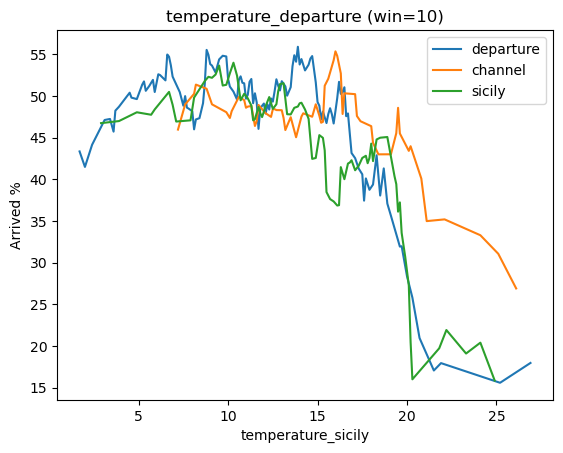

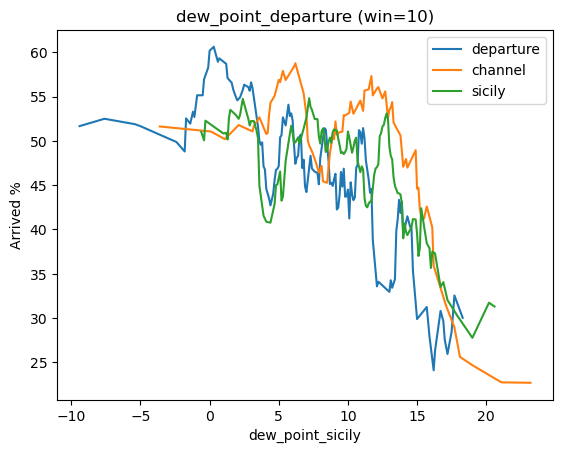

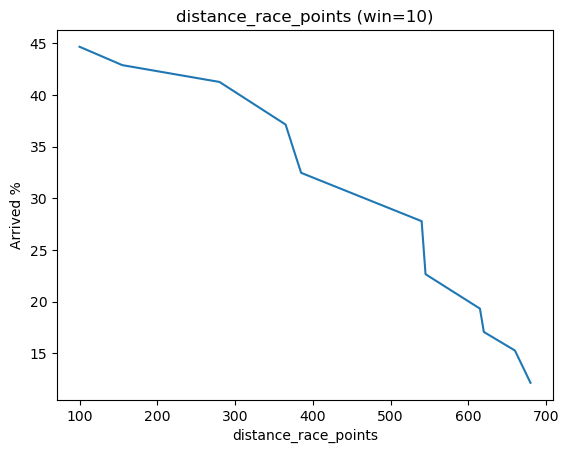

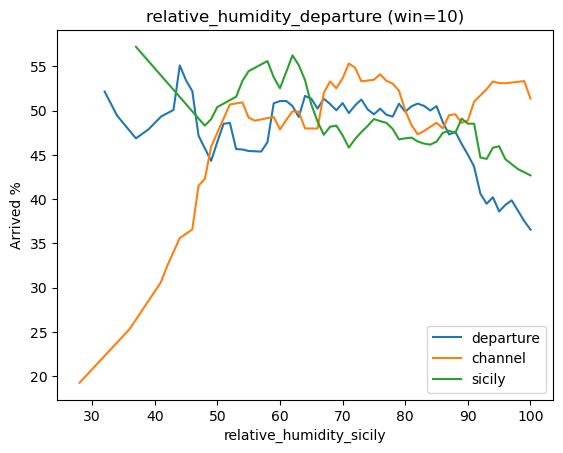

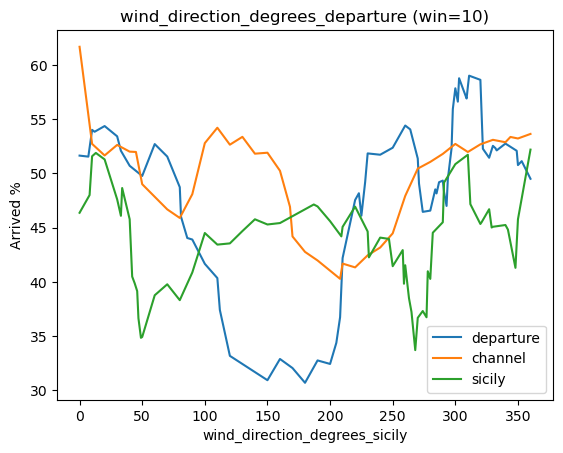

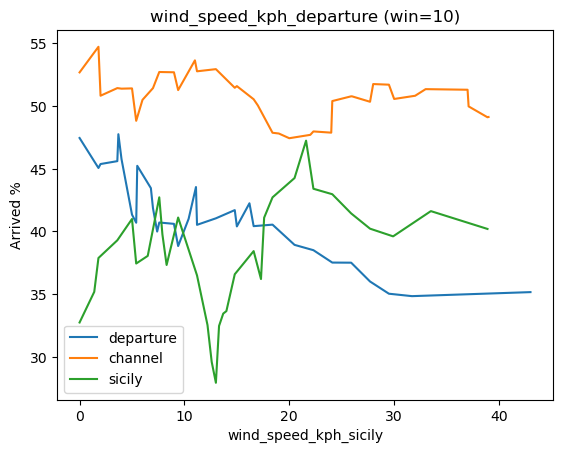

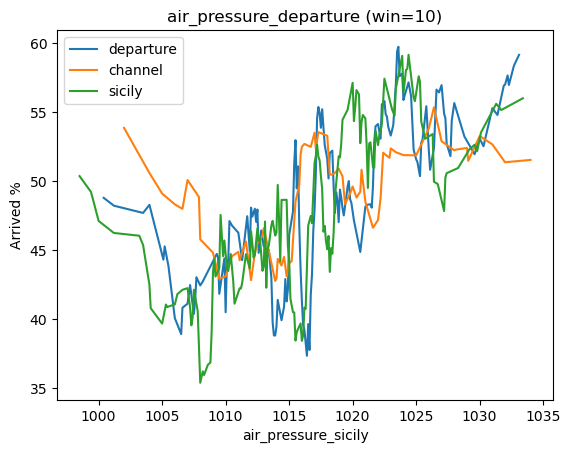

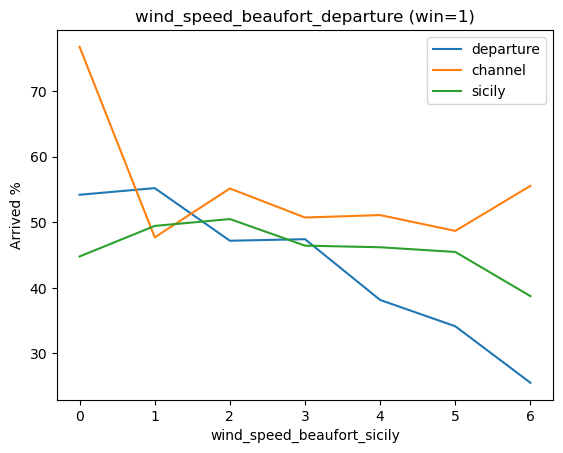

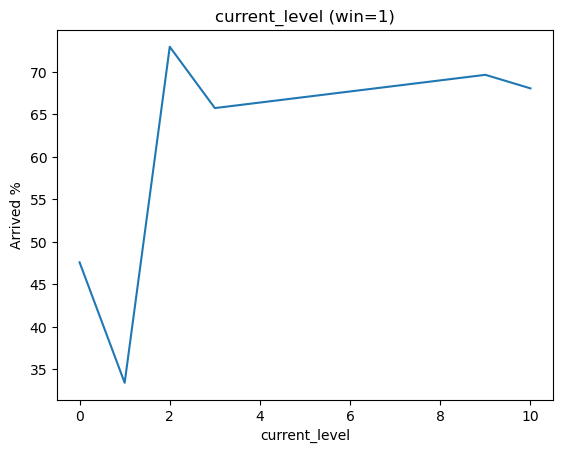

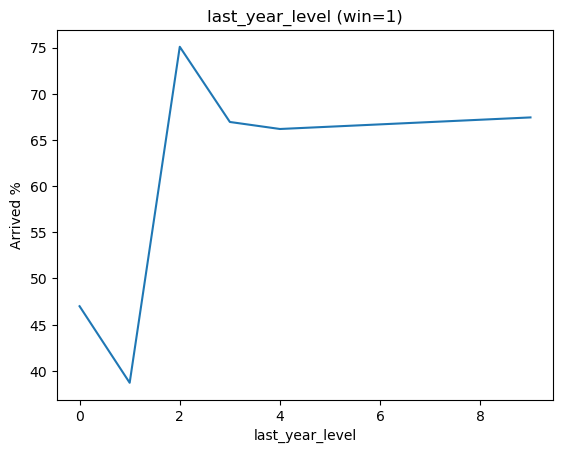

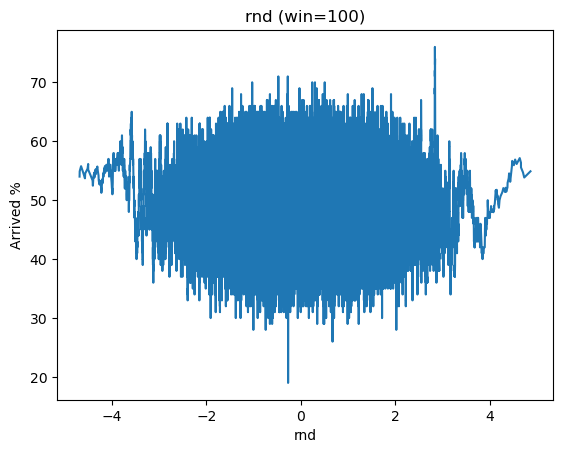

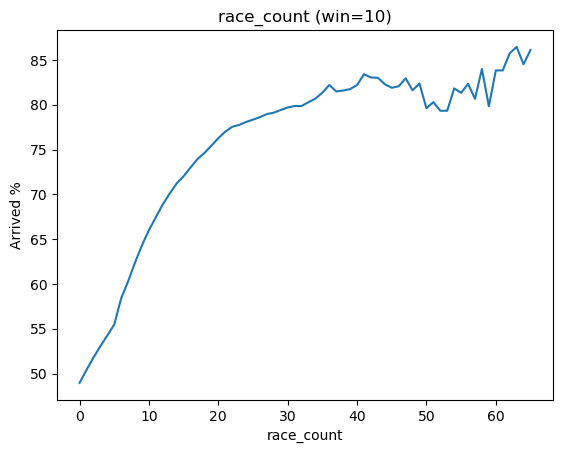

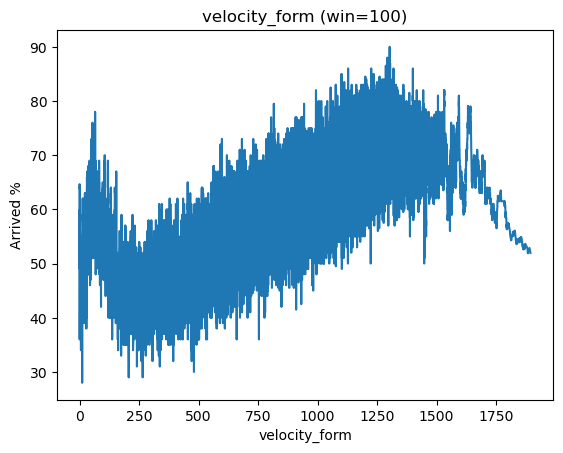

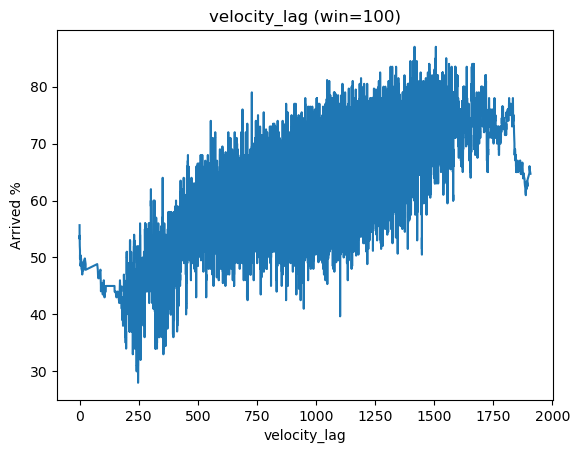

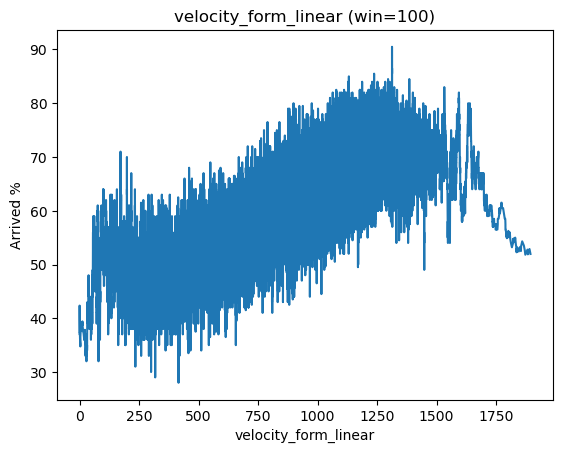

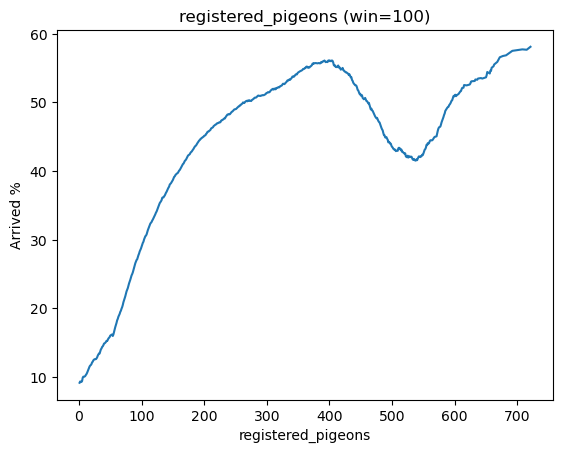

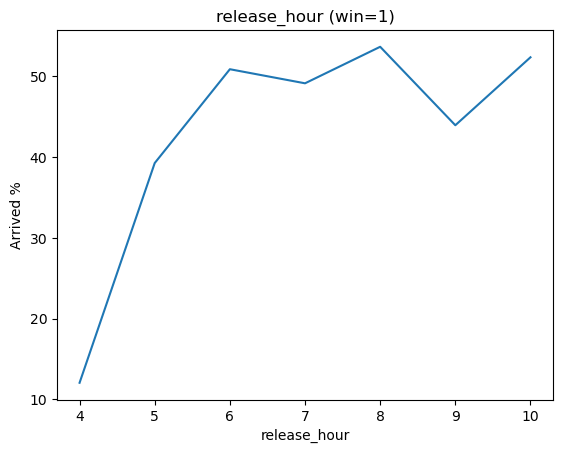

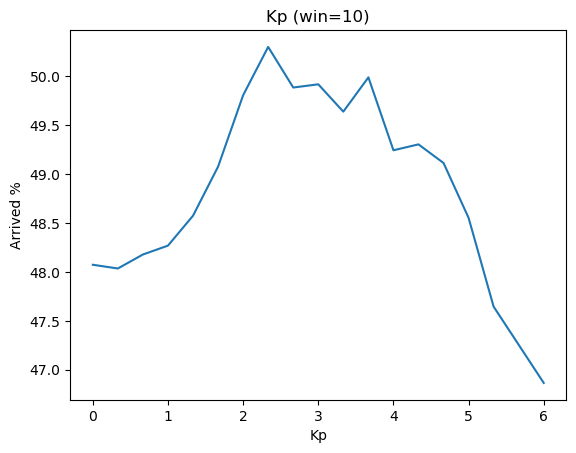

<Figure size 640x480 with 0 Axes>

In [69]:
for cov in covariates:
    if 'channel' in cov or 'sicily' in cov:
        continue
        
    print(cov)
    n_unique = len(df_race_results_final[cov].unique())
    if n_unique < 10:
        win = 1
    elif n_unique < 500:
        win = 10
    else:
        win = 100

    if 'departure' in cov:
        cov_channel = cov.replace('departure', 'channel')
        cov_sicily = cov.replace('departure', 'sicily')
        df_race_results_final.groupby(cov).arrived.mean().mul(100).rolling(win, min_periods=1, center=True).mean().sort_index().plot(label='departure')
        df_race_results_final.groupby(cov_channel).arrived.mean().mul(100).rolling(win, min_periods=1, center=True).mean().sort_index().plot(label='channel')
        df_race_results_final.groupby(cov_sicily).arrived.mean().mul(100).rolling(win, min_periods=1, center=True).mean().sort_index().plot(label='sicily')
        plt.legend()
    else:
        df_race_results_final.groupby(cov).arrived.mean().mul(100).rolling(win, min_periods=1, center=True).mean().sort_index().plot()
        
    plt.title(f'{cov} (win={win})')
    plt.ylabel('Arrived %')
    plt.figure()